# **Choosing Outperforming Stocks with Machine Learning**
### *By: Logan Chalifour*
### *Date: 12/21/2021*

### **Introduction**


This study wil examine the trailing twelve month returns (TTM) of the stocks in the S&P 500 to see if financial ratios can be leveraged to predict stocks that outperform the market using machine learning. Over the past 12 months the S&P 500 has returned roughly 26% to investors, so that would be the return realized if passively invested in the index. However, as we know, many investors would much rather prefer excess returns by making savvy stock picks. In the past, these stock picks were made based on bottom up research about each stock (equity research) which is a highly manual process prone to human bias. Machine learning has brought about a new wave of investing where stock picks may be automated in order to outperform the market. In this study, I will see if several machine learning algorithms such as Random Forest, Gaussian Naive Bayes, and SVCs can predict stocks that outperform the market. The models will be fed several financial metrics in an attempt to predict outperforming stocks.

### **Imports**

We start by importing some packages that we'll need.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

### **Data Cleaning**

After importing the necessary packages, we set a random seed to ensure our work is replicable.

In [2]:
np.random.seed(21)

We start by grabbing some general data about the companies in the S&P 500 from Wikipedia.

In [3]:
tables = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
wiki_df = tables[0]
wiki_df.to_csv('S&P500-Info.csv')

wiki_df

,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
0,MMM,3M,reports,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1976-08-09,66740,1902
1,ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
2,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
3,ABMD,Abiomed,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981
4,ACN,Accenture,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...,...,...
500,YUM,Yum! Brands,reports,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
501,ZBRA,Zebra Technologies,reports,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
502,ZBH,Zimmer Biomet,reports,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927
503,ZION,Zions Bancorp,reports,Financials,Regional Banks,"Salt Lake City, Utah",2001-06-22,109380,1873


Next, we manually grab some financial metrics pulled from FactSet that might be useful for predicting stock returns.

In [4]:
factset_df = pd.read_csv('S&P 500 FactSet Data.csv')

factset_df

,Symbol,Name,Price / Earnings,Price / Sales,Price / Book,PEG,EV / Sales,EV / EBITDA,EBIT Margin %,Piotroski F-Score,Mean Analyst Rating,TTM Total Return
0,MMM,3M Company,22.59,3.21,10.08,3.11,3.79,14.10,21.70,4.0,2.00,0.99
1,AOS,A. O. Smith Corporation,21.47,2.65,4.64,2.81,2.58,14.08,15.60,4.0,1.71,44.77
2,ABT,Abbott Laboratories,42.20,4.85,4.92,2.50,5.32,22.21,14.39,7.0,1.36,25.80
3,ABBV,"AbbVie, Inc.",16.75,3.95,NaN,0.82,4.77,9.93,41.83,6.0,1.32,31.27
4,ABMD,"ABIOMED, Inc.",32.76,7.91,6.13,3.75,7.40,23.07,29.57,4.0,1.67,7.78
...,...,...,...,...,...,...,...,...,...,...,...,...
495,YUM,"Yum! Brands, Inc.",24.37,5.63,NaN,3.20,7.51,20.08,33.82,7.0,1.73,21.86
496,ZBRA,Zebra Technologies Corporation Class A,25.64,3.14,7.50,NaN,3.45,17.73,15.35,6.0,1.58,53.02
497,ZBH,"Zimmer Biomet Holdings, Inc.",27.34,3.88,2.49,8.14,4.86,17.41,15.13,6.0,1.36,-21.22
498,ZION,"Zions Bancorporation, N.A.",12.38,2.98,1.26,NaN,4.18,NaN,NaN,NaN,1.75,48.29


In the dataframe above, `TTM Total Return` is our variable of interest or target variable. The other financial ratios are accurate as of a year ago, reflecting what inforamtion investors had at that point in time. Next, we combine the two dataframes by merging on the `symbol` column.

In [5]:
sp500_df = pd.merge(wiki_df, factset_df, how = "right", on=['Symbol', 'Symbol'])
sp500_df = sp500_df.drop(columns = ['SEC filings', 'Headquarters Location', 'CIK', 'Name', 'Date first added', 'Founded'])

sp500_df

,Symbol,Security,GICS Sector,GICS Sub-Industry,Price / Earnings,Price / Sales,Price / Book,PEG,EV / Sales,EV / EBITDA,EBIT Margin %,Piotroski F-Score,Mean Analyst Rating,TTM Total Return
0,MMM,3M,Industrials,Industrial Conglomerates,22.59,3.21,10.08,3.11,3.79,14.10,21.70,4.0,2.00,0.99
1,AOS,A. O. Smith,Industrials,Building Products,21.47,2.65,4.64,2.81,2.58,14.08,15.60,4.0,1.71,44.77
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,42.20,4.85,4.92,2.50,5.32,22.21,14.39,7.0,1.36,25.80
3,ABBV,AbbVie,Health Care,Pharmaceuticals,16.75,3.95,NaN,0.82,4.77,9.93,41.83,6.0,1.32,31.27
4,ABMD,Abiomed,Health Care,Health Care Equipment,32.76,7.91,6.13,3.75,7.40,23.07,29.57,4.0,1.67,7.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,YUM,Yum! Brands,Consumer Discretionary,Restaurants,24.37,5.63,NaN,3.20,7.51,20.08,33.82,7.0,1.73,21.86
496,ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments,25.64,3.14,7.50,NaN,3.45,17.73,15.35,6.0,1.58,53.02
497,ZBH,Zimmer Biomet,Health Care,Health Care Equipment,27.34,3.88,2.49,8.14,4.86,17.41,15.13,6.0,1.36,-21.22
498,ZION,Zions Bancorp,Financials,Regional Banks,12.38,2.98,1.26,NaN,4.18,NaN,NaN,NaN,1.75,48.29


We check the datatypes of each column to see if there is anything we need to change.

In [6]:
sp500_df.dtypes

Symbol                  object
Security                object
GICS Sector             object
GICS Sub-Industry       object
Price / Earnings       float64
Price / Sales          float64
Price / Book           float64
PEG                    float64
EV / Sales             float64
EV / EBITDA            float64
EBIT Margin %          float64
Piotroski F-Score      float64
Mean Analyst Rating    float64
TTM Total Return       float64
dtype: object

After checking the datatypes, everything looks okay, so we see if there are any null values.

In [7]:
sp500_df[sp500_df.isnull().any(axis=1)]

,Symbol,Security,GICS Sector,GICS Sub-Industry,Price / Earnings,Price / Sales,Price / Book,PEG,EV / Sales,EV / EBITDA,EBIT Margin %,Piotroski F-Score,Mean Analyst Rating,TTM Total Return
3,ABBV,AbbVie,Health Care,Pharmaceuticals,16.75,3.95,NaN,0.82,4.77,9.93,41.83,6.0,1.32,31.27
11,AFL,Aflac,Financials,Life & Health Insurance,11.95,1.77,1.33,1.79,2.07,NaN,NaN,NaN,2.13,29.26
15,ALK,Alaska Air Group,Industrials,Airlines,10.95,0.96,1.92,NaN,1.15,5.44,12.75,7.0,1.25,-2.01
17,ARE,Alexandria Real Estate Equities,Real Estate,Office REITs,51.80,11.87,2.20,11.31,17.29,24.70,33.22,NaN,1.17,25.80
21,ALL,Allstate Corp,Financials,Property & Casualty Insurance,8.02,0.84,1.51,1.07,1.05,NaN,NaN,NaN,1.47,7.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,WLTW,Willis Towers Watson,Financials,Insurance Brokers,25.15,2.91,2.54,2.27,3.56,14.87,15.05,NaN,1.72,14.65
491,WYNN,Wynn Resorts,Consumer Discretionary,Casinos & Gaming,120.80,2.25,8.55,NaN,3.46,14.16,14.83,4.0,1.53,-30.31
495,YUM,Yum! Brands,Consumer Discretionary,Restaurants,24.37,5.63,NaN,3.20,7.51,20.08,33.82,7.0,1.73,21.86
496,ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments,25.64,3.14,7.50,NaN,3.45,17.73,15.35,6.0,1.58,53.02


It appears that many of the financial metric columns have missing values so we fill them with the column mean.

In [8]:
sp500_df['Price / Earnings'].fillna(value=sp500_df['Price / Earnings'].mean(), inplace=True)
sp500_df['Price / Sales'].fillna(value=sp500_df['Price / Sales'].mean(), inplace=True)
sp500_df['Price / Book'].fillna(value=sp500_df['Price / Book'].mean(), inplace=True)
sp500_df['PEG'].fillna(value=sp500_df['PEG'].mean(), inplace=True)
sp500_df['EV / Sales'].fillna(value=sp500_df['EV / Sales'].mean(), inplace=True)
sp500_df['EV / EBITDA'].fillna(value=sp500_df['EV / EBITDA'].mean(), inplace=True)
sp500_df['EBIT Margin %'].fillna(value=sp500_df['EBIT Margin %'].mean(), inplace=True)
sp500_df['Piotroski F-Score'].fillna(value=sp500_df['Piotroski F-Score'].mean(), inplace=True)
sp500_df['Mean Analyst Rating'].fillna(value=sp500_df['Mean Analyst Rating'].mean(), inplace=True)
sp500_df['TTM Total Return'].fillna(value=sp500_df['TTM Total Return'].mean(), inplace=True)

We check for null values again to make sure we correctly filled the missing values.

In [9]:
sp500_df[sp500_df.isnull().any(axis=1)]

,Symbol,Security,GICS Sector,GICS Sub-Industry,Price / Earnings,Price / Sales,Price / Book,PEG,EV / Sales,EV / EBITDA,EBIT Margin %,Piotroski F-Score,Mean Analyst Rating,TTM Total Return
266,KSU,NaN,NaN,NaN,28.36,5.33,3.33,2.46,6.57,13.3,36.81,7.0,1.55,24.317871


It looks like the stock with ticker "KSU" is a bit of an outlier with little identifying info, so we drop it from our dataset.

In [10]:
sp500_df = sp500_df.dropna()
sp500_df

,Symbol,Security,GICS Sector,GICS Sub-Industry,Price / Earnings,Price / Sales,Price / Book,PEG,EV / Sales,EV / EBITDA,EBIT Margin %,Piotroski F-Score,Mean Analyst Rating,TTM Total Return
0,MMM,3M,Industrials,Industrial Conglomerates,22.59,3.21,10.080000,3.110000,3.79,14.100000,21.700000,4.000000,2.00,0.99
1,AOS,A. O. Smith,Industrials,Building Products,21.47,2.65,4.640000,2.810000,2.58,14.080000,15.600000,4.000000,1.71,44.77
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,42.20,4.85,4.920000,2.500000,5.32,22.210000,14.390000,7.000000,1.36,25.80
3,ABBV,AbbVie,Health Care,Pharmaceuticals,16.75,3.95,10.106255,0.820000,4.77,9.930000,41.830000,6.000000,1.32,31.27
4,ABMD,Abiomed,Health Care,Health Care Equipment,32.76,7.91,6.130000,3.750000,7.40,23.070000,29.570000,4.000000,1.67,7.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,YUM,Yum! Brands,Consumer Discretionary,Restaurants,24.37,5.63,10.106255,3.200000,7.51,20.080000,33.820000,7.000000,1.73,21.86
496,ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments,25.64,3.14,7.500000,10.272792,3.45,17.730000,15.350000,6.000000,1.58,53.02
497,ZBH,Zimmer Biomet,Health Care,Health Care Equipment,27.34,3.88,2.490000,8.140000,4.86,17.410000,15.130000,6.000000,1.36,-21.22
498,ZION,Zions Bancorp,Financials,Regional Banks,12.38,2.98,1.260000,10.272792,4.18,18.800716,16.509115,5.426065,1.75,48.29


We see our cleaned dataframe with 499 stocks, each with 14 features.

### **Explortatory Data Analysis**

We start our EDA by looking at the unique GICS sectors to get an idea of what industries we are looking at.

In [11]:
sorted(sp500_df['GICS Sector'].unique())

['Communication Services',
 'Consumer Discretionary',
 'Consumer Staples',
 'Energy',
 'Financials',
 'Health Care',
 'Industrials',
 'Information Technology',
 'Materials',
 'Real Estate',
 'Utilities']

To get a better understanding of the trailing twelve month return for all the stocks, we take a look at a historgram showing the distribution.

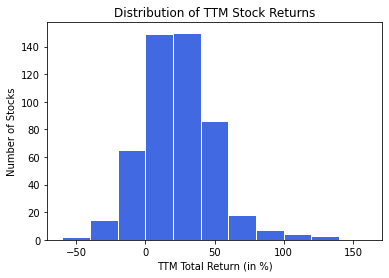

In [12]:
plt.hist(sp500_df['TTM Total Return'], bins = [-60, -40, -20, 0, 20, 40, 60, 80, 100, 120, 140, 160], color = 'royalblue', edgecolor = 'white')
plt.title('Distribution of TTM Stock Returns')
plt.ylabel('Number of Stocks')
plt.xlabel('TTM Total Return (in %)');
plt.show()

As seen above, most stocks returned between 0 and 40% which makes sense since the S&P 500 return was roughly 26% on the year. Let's now take a look at a heatmap to see how these features are related to the target variable, `TTM Total Return`.

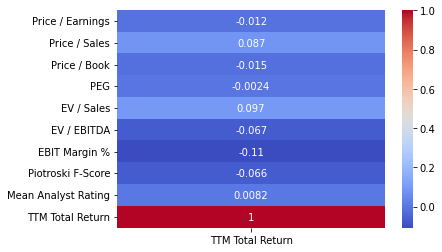

In [13]:
corrMatrix = sp500_df.corr()
sns.heatmap(corrMatrix[['TTM Total Return']], annot=True, cmap='coolwarm')

As seen above, most of the variables have a minimal correlation with our target variable. However, picking stocks in an efficient market is not always easy so even a slight edge given by these variables will be helpful to us.

### **Unsupervised Machine Learning**

Before diving in to our supervised learning, we conduct some unsupervised learning to see what the machine can learn first. We start by preparing our dataframe for a hierarchical clustering dendrogram.

In [14]:
num_df = sp500_df.drop(['Security', 'GICS Sector', 'GICS Sub-Industry'], axis=1)
num_df = num_df.set_index('Symbol')
num_df

,Price / Earnings,Price / Sales,Price / Book,PEG,EV / Sales,EV / EBITDA,EBIT Margin %,Piotroski F-Score,Mean Analyst Rating,TTM Total Return
Symbol,,,,,,,,,,
MMM,22.59,3.21,10.080000,3.110000,3.79,14.100000,21.700000,4.000000,2.00,0.99
AOS,21.47,2.65,4.640000,2.810000,2.58,14.080000,15.600000,4.000000,1.71,44.77
ABT,42.20,4.85,4.920000,2.500000,5.32,22.210000,14.390000,7.000000,1.36,25.80
ABBV,16.75,3.95,10.106255,0.820000,4.77,9.930000,41.830000,6.000000,1.32,31.27
ABMD,32.76,7.91,6.130000,3.750000,7.40,23.070000,29.570000,4.000000,1.67,7.78
...,...,...,...,...,...,...,...,...,...,...
YUM,24.37,5.63,10.106255,3.200000,7.51,20.080000,33.820000,7.000000,1.73,21.86
ZBRA,25.64,3.14,7.500000,10.272792,3.45,17.730000,15.350000,6.000000,1.58,53.02
ZBH,27.34,3.88,2.490000,8.140000,4.86,17.410000,15.130000,6.000000,1.36,-21.22


With categorical features removed, we construct our dendrogram with the full pool of roughly 500 stocks.

{'color_list': ['g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',

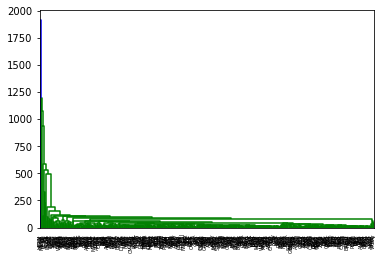

In [15]:
Z = linkage(num_df, method='average')
dendrogram(Z, labels = num_df.index, leaf_rotation = 90)

As you can see above, the ~500 stocks overload our dendrogram, so we take a look at a smaller portion of 20 stocks.

{'color_list': ['g',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'b',
  'b'],
 'dcoord': [[0.0, 27.12248443356283, 27.12248443356283, 0.0],
  [0.0, 13.936767354924083, 13.936767354924083, 0.0],
  [0.0, 22.94700935302444, 22.94700935302444, 13.936767354924083],
  [0.0, 27.09166420632991, 27.09166420632991, 22.94700935302444],
  [0.0, 30.305917992084282, 30.305917992084282, 0.0],
  [0.0, 8.295155212532194, 8.295155212532194, 0.0],
  [0.0, 8.438465500314617, 8.438465500314617, 0.0],
  [8.295155212532194,
   14.766164673967923,
   14.766164673967923,
   8.438465500314617],
  [0.0, 6.1306117149922335, 6.1306117149922335, 0.0],
  [0.0, 13.41788537912889, 13.41788537912889, 6.1306117149922335],
  [0.0, 19.335885177423037, 19.335885177423037, 13.41788537912889],
  [0.0, 23.260914868933117, 23.260914868933117, 19.335885177423037],
  [14.766164673967923,
   26.658871828567648,
   26.658871828567648,
   23.260914868933117],
  [0.0, 34

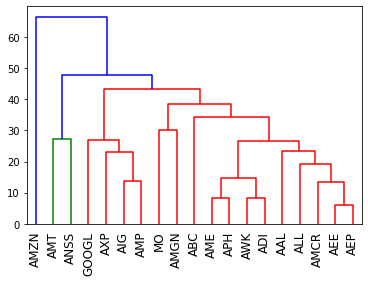

In [16]:
num_df = num_df[21:40]

Z = linkage(num_df, method='average')
dendrogram(Z, labels = num_df.index, leaf_rotation = 90)

Much better - now we can clearly see three separate clusters that show how similar and/or different the stocks are from one another. If we look further at these clusters it becomes apparent that they have similar financial profiles due to their ratios.

### **Supervised Machine Learning**

In [17]:
#S&P 500 return is roughly 26% over TTM
sp500_df['Outperform'] = np.where(sp500_df['TTM Total Return'] > 26, 1, 0)
sp500_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Symbol,Security,GICS Sector,GICS Sub-Industry,Price / Earnings,Price / Sales,Price / Book,PEG,EV / Sales,EV / EBITDA,EBIT Margin %,Piotroski F-Score,Mean Analyst Rating,TTM Total Return,Outperform
0,MMM,3M,Industrials,Industrial Conglomerates,22.59,3.21,10.080000,3.110000,3.79,14.100000,21.700000,4.000000,2.00,0.99,0
1,AOS,A. O. Smith,Industrials,Building Products,21.47,2.65,4.640000,2.810000,2.58,14.080000,15.600000,4.000000,1.71,44.77,1
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,42.20,4.85,4.920000,2.500000,5.32,22.210000,14.390000,7.000000,1.36,25.80,0
3,ABBV,AbbVie,Health Care,Pharmaceuticals,16.75,3.95,10.106255,0.820000,4.77,9.930000,41.830000,6.000000,1.32,31.27,1
4,ABMD,Abiomed,Health Care,Health Care Equipment,32.76,7.91,6.130000,3.750000,7.40,23.070000,29.570000,4.000000,1.67,7.78,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,YUM,Yum! Brands,Consumer Discretionary,Restaurants,24.37,5.63,10.106255,3.200000,7.51,20.080000,33.820000,7.000000,1.73,21.86,0
496,ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments,25.64,3.14,7.500000,10.272792,3.45,17.730000,15.350000,6.000000,1.58,53.02,1
497,ZBH,Zimmer Biomet,Health Care,Health Care Equipment,27.34,3.88,2.490000,8.140000,4.86,17.410000,15.130000,6.000000,1.36,-21.22,0
498,ZION,Zions Bancorp,Financials,Regional Banks,12.38,2.98,1.260000,10.272792,4.18,18.800716,16.509115,5.426065,1.75,48.29,1


In [18]:
x_stocks = sp500_df.drop(['Symbol', 'Security', 'GICS Sector', 'GICS Sub-Industry', 'TTM Total Return', 'Outperform'], axis=1)
y_stocks = sp500_df['Outperform']

In [19]:
x_stocks.shape

(499, 9)

In [20]:
y_stocks.shape

(499,)

In [21]:
x_train, x_test, y_train, y_test = train_test_split(x_stocks, y_stocks, test_size = 0.2)

In [22]:
m1 = RandomForestClassifier(n_estimators=100, random_state=0)
m1.fit(x_train, y_train)
y_m1 = m1.predict(x_test)

m2 = GaussianNB()
m2.fit(x_train, y_train)
y_m2 = m2.predict(x_test)

m3 = SVC(C=1E1)
m3.fit(x_train, y_train)
y_m3 = m3.predict(x_test)

print("Random Forest Accuracy:")
print(accuracy_score(y_test, y_m1))

print("Gaussian Naive Bayes Accuracy:")
print( accuracy_score(y_test, y_m2))

print("SVC Accuracy:")
print(accuracy_score(y_test, y_m3))

Random Forest Accuracy:
0.63
Gaussian Naive Bayes Accuracy:
0.57
SVC Accuracy:
0.54


In [23]:
importances = m1.feature_importances_
feature_importances = pd.DataFrame({'feature':x_test.columns, 'importance':importances})
feature_importances = feature_importances.sort_values(by=['importance'], ascending=False)
feature_importances

,feature,importance
2,Price / Book,0.136075
4,EV / Sales,0.123430
1,Price / Sales,0.122455
0,Price / Earnings,0.120010
5,EV / EBITDA,0.115398
6,EBIT Margin %,0.114322
8,Mean Analyst Rating,0.107876
3,PEG,0.106710
7,Piotroski F-Score,0.053724


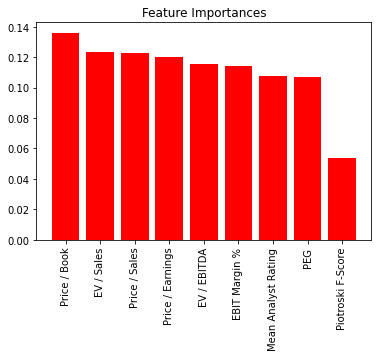

In [24]:
plt.figure()
plt.title("Feature Importances")
plt.bar(feature_importances['feature'], feature_importances['importance'],
       color="r", align="center")
plt.xticks(rotation = 90)

plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


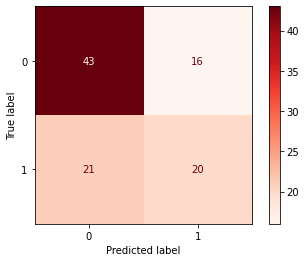

In [25]:
tn, fp, fn, tp = confusion_matrix(y_test, y_m1).ravel()

plot_confusion_matrix(m1, x_test, y_test, cmap='Reds')  
plt.show()

In [26]:
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
precsion = tp / (tp + fp)
F1score = 2 * ((precsion * sensitivity) / (precsion + sensitivity))

print("Sensitivity:", sensitivity.round(2))
print("Specificity:", specificity.round(2))
print("Precision:", precsion.round(2))
print("F1 Score:", F1score.round(2))

Sensitivity: 0.49
Specificity: 0.73
Precision: 0.56
F1 Score: 0.52


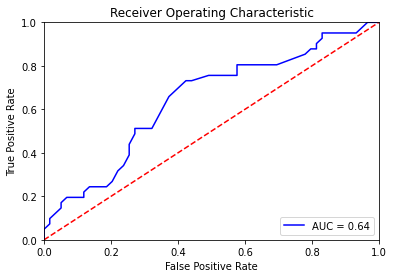

In [27]:
import sklearn.metrics as metrics

# calculate the fpr and tpr for all thresholds of the classification
probs = m1.predict_proba(x_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()